<a href="https://colab.research.google.com/github/shreyas269/programming/blob/master/machine_learning/Conv_CIFAR10_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# Hyperparameters
std = np.array((0.5, 0.5, 0.5))
mean = np.array((0.5, 0.5, 0.5))
epochs = 15
training_batch_size = 100
validation_batch_size = 100
lrn_rate = 0.001

In [0]:
# Declaring and assigning Hyperparameters in a namedtuple
HParams = namedtuple('HPS', 'std, mean, epochs, training_batch_size, validation_batch_size, lrn_rate')
hps = HParams(std=std, mean=mean, epochs=epochs, training_batch_size=training_batch_size, validation_batch_size=validation_batch_size, lrn_rate=lrn_rate)

In [0]:
# In PyTorch, images are represented as [channels, height, width]
# For a 256x256 coloured image, [channels, height, width] = [3, 256, 256]
# For grayscale, channels=1

# "transforms" are common image transformations
# tansforms.Compose chains together transformations
# ToTensor() converts numpy array (PIL image) to FloatTensor in range [0.0, 1.0]. Transforms numpy [H, W, C] to Tensor [C, H, W]

transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Three channels to normalize since CIFAR is RGB
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# This maps image FloatTensor values from [0.0, 1.0] to [-1.0, 1.0]

In [6]:
training_dataset = datasets.CIFAR10(root='./data', download=True, train=True, transform=transform_train)
training_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
validation_dataset = datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
validation_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
# tensor.detach() creates a tensor that shares storage with tensor that does not require grad, i.e. detaches output from computation graph.

# Converts tensor image to numpy
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() # Is now [C, H, W]
  image = image.transpose(1, 2, 0) # Is now [H, W, C]

  # Denormalize the image
  # 1. Convert [-1, 1] to [0, 1]

  print(image.shape)
  
  image = image * std + mean
  image.clip(0, 1) # To ensure image value is between [0, 1]

  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


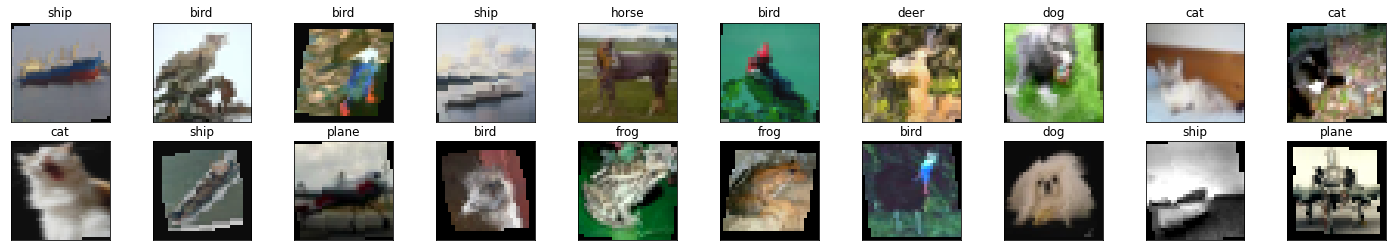

In [10]:
# Provides an iterable over the given dataset as per the sampler provided (optional). Set shuffle=True for default random sampler.
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=hps.training_batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=hps.validation_batch_size, shuffle=False)

data_iter = iter(training_loader)
images, labels = data_iter.next() # Grabs first batch of data

images = images.to(device)
labels = labels.to(device)

# show sampled training images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
# NN Class model
class LeNet(nn.Module):
    def __init__(self):
      super().__init__() # To inherit all methods from parent class

      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # args = (input_channels, output_channels, kernel_size, stride_length)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

      # Calculations: 
      # No. of neurons in FC1 is (Number of channels)*(size of each channel after max pooling in conv3)
      # 32x32 -> conv1 -> 32x32 (after padding) -> max_pool1 -> 16x16 -> conv2 -> 16x16 (after padding) -> max_pool2 -> 8x8 -> conv3 -> 8x8 (after padding) -> max_pool3 -> 4x4
      # size of each channel after max pooling in conv3 = 4*4
      # Number of channels = 64
      # No. of neurons in FC1 = 64*(4*4)

      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
      # Defining architecture of NN
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2) # 2x2 kernel_size
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64) # Changes to 1x4*4*64 row vector
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)

      return x

In [12]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
# Define Loss
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD, Adam etc)
optimizer = torch.optim.Adam(model.parameters(), lr=hps.lrn_rate)

In [0]:
def pred_image_loader(loader):
  for inputs, labels in loader:
    inputs = inputs.view(inputs.shape[0], -1) # (1, 28, 28) -> (1, 784). The "-1" infers the remaining value automatically.
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss+=loss.item()

    _, preds = torch.max(outputs, 1) 
    correct_preds = (preds == labels.data)
    running_corrects += torch.sum(correct_preds)
  
  return running_loss, running_corrects

In [0]:
def run_image_loader(loader, mode): # mode is either 'train' or 'eval'
  running_loss = 0.0  # Accumulates loss from all training examples in the batch
  running_corrects = 0.0 # Accumulates accuracy from all training examples in the batch

  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    training = False
    if mode=='train':
      training=True
    elif mode not in ['train', 'eval']:
      print("Invalid mode: ", mode, " used")
      print("Using default 'eval' mode")

    if(training==True):
      # Zero the gradients to avoid accumulation
      optimizer.zero_grad()

      # Find the gradient values
      loss.backward()

      # Optimize the parameter values by subtracting lr*gradient
      optimizer.step()

    running_loss+=loss.item()

    _, preds = torch.max(outputs, 1) 
    correct_preds = (preds == labels.data)
    running_corrects += torch.sum(correct_preds)
  
  return running_loss, running_corrects

In [16]:
running_loss_history = [] # List containing training Loss values of a batch in every epoch
running_accuracy_history = [] # List containing training accuracy values of a batch in every epoch

val_running_loss_history = [] # List containing validation Loss values of a batch in every epoch
val_running_accuracy_history = [] # List containing validation accuracy values of a batch in every epoch

for e in range(hps.epochs):
  running_loss, running_corrects = run_image_loader(training_loader, 'train')

  with torch.no_grad(): # No need for gradients while predicting on validation set
      val_running_loss, val_running_corrects = run_image_loader(validation_loader, 'eval')

  epoch_loss = running_loss/len(training_loader) # epoch_loss is average loss of input example
  epoch_accuracy = running_corrects.float()/len(training_loader) # epoch_accuracy is accuracy of model over the partially trained model at a particular epoch

  running_loss_history.append(epoch_loss)
  running_accuracy_history.append(epoch_accuracy)

  val_epoch_loss = val_running_loss/len(validation_loader) # epoch_loss is average loss of input example
  val_epoch_accuracy = val_running_corrects.float()/len(validation_loader) # epoch_accuracy is accuracy of model over the partially trained model at a particular epoch

  val_running_loss_history.append(val_epoch_loss)
  val_running_accuracy_history.append(val_epoch_accuracy)

  print("epoch: {}, training loss: {:.4f}, training accuracy: {:.4f}, validation loss: {:.4f}, validation accuracy: {:.4f}".format(e+1, epoch_loss, epoch_accuracy.item(), val_epoch_loss, val_epoch_accuracy.item()))

epoch: 1, training loss: 1.6891, training accuracy: 37.7460, validation loss: 1.4081, validation accuracy: 48.9100
epoch: 2, training loss: 1.4020, training accuracy: 49.1200, validation loss: 1.2361, validation accuracy: 55.1500
epoch: 3, training loss: 1.2638, training accuracy: 54.5860, validation loss: 1.1235, validation accuracy: 59.8200
epoch: 4, training loss: 1.1689, training accuracy: 58.3680, validation loss: 1.0375, validation accuracy: 63.4500
epoch: 5, training loss: 1.0993, training accuracy: 60.8360, validation loss: 0.9720, validation accuracy: 65.3200
epoch: 6, training loss: 1.0527, training accuracy: 62.7960, validation loss: 0.9457, validation accuracy: 66.5500
epoch: 7, training loss: 1.0054, training accuracy: 64.4280, validation loss: 0.9129, validation accuracy: 68.0800
epoch: 8, training loss: 0.9682, training accuracy: 65.9200, validation loss: 0.8802, validation accuracy: 69.7400
epoch: 9, training loss: 0.9427, training accuracy: 66.8740, validation loss: 0.

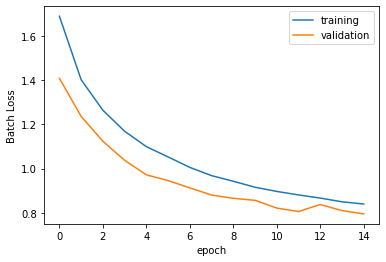

In [17]:
plt.plot(running_loss_history, label='training')
plt.plot(val_running_loss_history, label='validation')
plt.ylabel('Batch Loss')
plt.xlabel('epoch')
plt.legend()

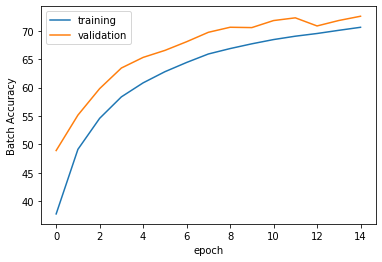

In [18]:
plt.plot(running_accuracy_history, label='training')
plt.plot(val_running_accuracy_history, label='validation')
plt.ylabel('Batch Accuracy')
plt.xlabel('epoch')
plt.legend()